<center><img src="img/logo.png"></center>

<h2> <center> 3 февраля 2021 г.</center> <center> Москва</center> </h2>

<h1> <center>Туториал</center> </h1>
<h2> <center>По обнаружению аномалий и точек разладки генеративными моделями</center> </h2>

Content:
- Intro
- Generative Adversarial Network (GAN)
- Wasserstein GAN (WGAN)
- Anomalies Detection with WGAN
- Bidirectional GAN (BiGAN)
- Anomalies Detection with BiGAN
- Additional Resources
- Additional Task

# Intro

<center><img src="img/alma.png" width="400"></center>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data Preparation

The data are MC generated (see below) to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Depending on the energy of the primary gamma, a total of few hundreds to some 10000 Cherenkov photons get collected, in patterns (called the shower image), allowing to discriminate statistically those caused by primary gammas (signal) from the images of hadronic showers initiated by cosmic rays in the upper atmosphere (background). Typically, the image of a shower after some pre-processing is an elongated cluster.

Attribute Information:

0. fLength: continuous # major axis of ellipse [mm]
1. fWidth: continuous # minor axis of ellipse [mm]
2. fSize: continuous # 10-log of sum of content of all pixels [in #phot]
3. fConc: continuous # ratio of sum of two highest pixels over fSize [ratio]
4. fConc1: continuous # ratio of highest pixel over fSize [ratio]
5. fAsym: continuous # distance from highest pixel to center, projected onto major axis [mm]
6. fM3Long: continuous # 3rd root of third moment along major axis [mm]
7. fM3Trans: continuous # 3rd root of third moment along minor axis [mm]
8. fAlpha: continuous # angle of major axis with vector to origin [deg]
9. fDist: continuous # distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

Link: https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope

In [2]:
! wget https://raw.githubusercontent.com/HSE-LAMBDA/OpenTalks2021_tutorial/main/data/MAGIC/magic04.data

--2021-02-02 18:50:37--  https://raw.githubusercontent.com/HSE-LAMBDA/OpenTalks2021_tutorial/main/data/MAGIC/magic04.data
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1477391 (1.4M) [text/plain]
Saving to: ‘magic04.data.3’

magic04.data.3      100%[===================>]   1.41M  4.74MB/s    in 0.3s    

2021-02-02 18:50:37 (4.74 MB/s) - ‘magic04.data.3’ saved [1477391/1477391]



In [3]:
# read data
data = pd.read_csv("magic04.data", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,10
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


Firstly, for the simplicity we select only 2 features of the data and inject synthetic outliers.

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

In [5]:
n_samples = 2000
outliers_fraction = 0.02
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

In [6]:
# read inliers
X_inliers = resample(data[[2, 4]].values, replace=False, n_samples=n_inliers, random_state=42)
X_inliers = StandardScaler().fit_transform(X_inliers)

# generate outliers
X_outliers = np.random.RandomState(42).uniform(low=-6, high=6, size=(n_outliers, 2))

In [7]:
# concatenate
X = np.concatenate((X_inliers, X_outliers), axis=0)
y = np.array([0]*len(X_inliers) + [1]*len(X_outliers))

In [8]:
def plot_Xy(X, y):
    plt.figure(figsize=(5, 5))
    plt.scatter(X[y==0, 0], X[y==0, 1], label='Inliers')
    plt.scatter(X[y==1, 0], X[y==1, 1], label='Outliers')
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.xlabel(r'$X_1$', size=14)
    plt.ylabel(r'$X_2$', size=14)
    plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
    plt.legend(loc='best', fontsize=14)
    plt.show()

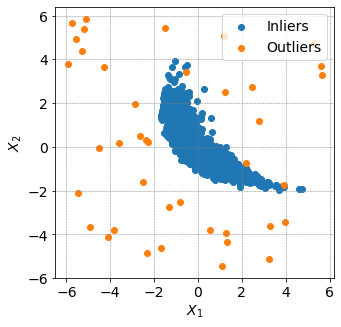

In [9]:
plot_Xy(X, y)

# Train / Test Split

In [10]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11)

Train:


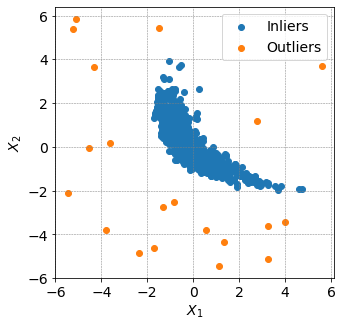

Test:


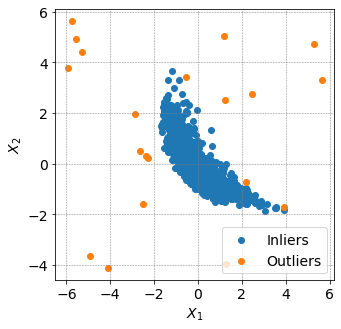

In [11]:
print("Train:")
plot_Xy(X_train, y_train)
print("Test:")
plot_Xy(X_test, y_test)

# Generative Adversarial Network (GAN)

<center><img src="img/GAN_en.png" width=600></center>

Notations:
- $z$ - a random object in latent space;
- $x$ - a real object in feature space;
- $G(z)$ - a generator neural network of the GAN;
- $D(x)$ - a discriminator neural network of the GAN.


<center><img src="img/gan_algo.png" width=600></center>

Link: https://arxiv.org/abs/1406.2661

# Wasserstein GAN (WGAN)

`Wasserstein distance` of `Eatch Mover's distance` represents the best 'moving plan' with the smallest average distance to move one distribution into another one:
<center><img src="img/wdist.png" width=900></center>

This distance is used as a loss function for a Discriminator in WGAN. Here:
- g(z) - Generator;
- f(x) - Discriminator.

<center><img src="img/wgan_algo.png" width=600></center>

Link: https://arxiv.org/abs/1701.07875

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Let's define a Generator of our GAN.

In [13]:
class Generator(nn.Module):
    
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(n_inputs, 100)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 100)
        self.act2 = nn.ReLU()
        self.fc_out = nn.Linear(100, n_outputs)

    def forward(self, x_noise):
        x = x_noise
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc_out(x)
        return x

Now, let's also define a Discriminator of the GAN.

In [14]:
class Discriminator(nn.Module):
    
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(n_inputs, 100)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 100)
        self.act2 = nn.ReLU()
        self.fc_out = nn.Linear(100, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc_out(x)
        return x

In this example we implement `WGAN` wiht Wassestein distance as a loss function. Let's train our GAN.

In [15]:
class Fitter(object):
    
    def __init__(self, generator, discriminator, batch_size=32, n_epochs=10, latent_dim=1, lr=0.0001, n_critic=5):
        
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic
        
        self.opt_gen  = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)
        
        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)
    
    
    def fit(self, X):
        
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        dataset_real = TensorDataset(X_real)
        
        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)
        
        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch,) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)):
                
                # generate a batch of fake observations
                fake_batch = self.generate(len(real_batch))
    
                ### Discriminator
                # measure discriminator's ability to classify real from fake samples
                loss_disc = -torch.mean(self.discriminator(real_batch)) + torch.mean(self.discriminator(fake_batch))

                # optimization step
                self.opt_disc.zero_grad()
                loss_disc.backward(retain_graph=True)
                self.opt_disc.step()

                # Clip weights of discriminator
                for p in discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)
                    
                ### Generator
                if i % self.n_critic == 0:
                    
                    # measures generator's ability to fool the discriminator
                    loss_gen = torch.mean(self.discriminator(real_batch)) - torch.mean(self.discriminator(fake_batch))
                    
                    # optimization step
                    self.opt_gen.zero_grad()
                    loss_gen.backward()
                    self.opt_gen.step()
                    
            # caiculate and store loss after an epoch
            X_fake = self.generate(len(X_real))
            loss_epoch = torch.mean(self.discriminator(X_real)) - torch.mean(self.discriminator(X_fake))
            self.loss_history.append(loss_epoch.detach().cpu())
                    
        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)
        
        
    def generate(self, N):
        noise = Variable(torch.tensor(np.random.normal(0, 1, (N, self.latent_dim)), dtype=torch.float, device=DEVICE))
        # noise = Variable(torch.tensor(2*np.random.rand(N, self.latent_dim)-1, dtype=torch.float, device=DEVICE))
        X_gen = self.generator(noise)
        return X_gen
    
    def discriminate(self, X):
        intput = torch.tensor(X, dtype=torch.float, device=DEVICE)
        output = self.discriminator(intput).detach().numpy()
        return output

Finally, we will train our WGAN on normal data.

In [16]:
%%time
latent_dim = 2
generator     = Generator(latent_dim, 2)
discriminator = Discriminator(2)

fitter = Fitter(generator, discriminator, batch_size=50, n_epochs=1000, latent_dim=latent_dim, lr=0.0001, n_critic=5)
fitter.fit(X_train[y_train==0])

CPU times: user 1min 28s, sys: 1.73 s, total: 1min 30s
Wall time: 1min 32s


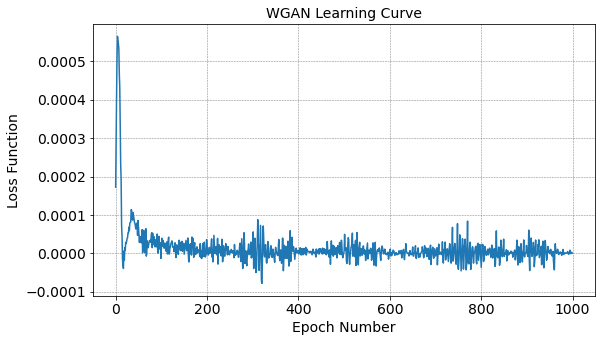

In [17]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("WGAN Learning Curve", size=14)
plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
plt.show()

Consider examples of generated objects.

### X = G(Z)

In [18]:
# sample objects from known distribution in latent space Z
Z_gen = torch.tensor(np.random.normal(0, 1, (len(X_train), latent_dim)), dtype=torch.float, device=DEVICE)

# using object in latent sapce, generate fake objects using the Generator
X_gen = fitter.generator(Z_gen).cpu().detach().numpy()
Z_gen = Z_gen.cpu().detach().numpy()

In [19]:
def plot_generated_objs(Z_gen, X_gen, X):

    plt.figure(figsize=(2*5, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(Z_gen[:, 0], Z_gen[:, 1], label="Fake", color='C0')
    plt.xlabel(r"$Z_1$", size=14)
    plt.ylabel(r"$Z_2$", size=14)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.title("Latent Space", size=14)
    plt.legend(loc='best', fontsize=14)
    plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')

    plt.subplot(1, 2, 2)
    plt.scatter(X[:, 0], X[:, 1], label="Real", color='C1')
    plt.scatter(X_gen[:, 0], X_gen[:, 1], label="Fake", color='C0')
    plt.xlabel(r"$X_1$", size=14)
    plt.ylabel(r"$X_2$", size=14)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.title("Feature Space", size=14)
    plt.legend(loc='best', fontsize=14)
    plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
    plt.show()

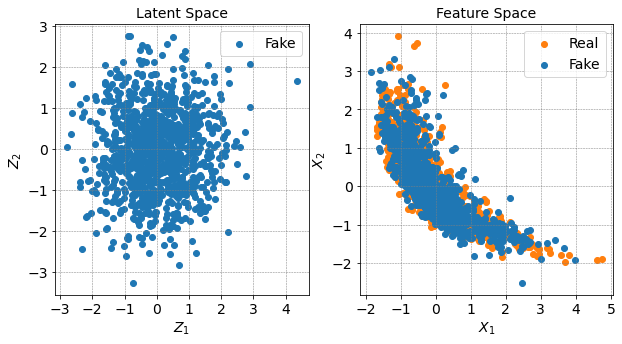

In [20]:
plot_generated_objs(Z_gen, X_gen, X_train[y_train==0])

Now, let's consider what the Generator does more detailed.

### $X_1 = G(Z_1)$ for inliers in Z
### $X_2 = G(Z_2)$ for outliers in Z

In [21]:
r_min = 3
r_max = 5

In [22]:
# sample objects in latent space Z uniformly
Z_outliers = np.random.uniform(low=-10, high=10, size=(5000, 2))

# select all objects within r_min and r_max radius
r = np.sqrt(Z_outliers[:, 0]**2 + Z_outliers[:, 1]**2)
Z_outliers = Z_outliers[(r >= r_min)*(r < r_max)]

# generate object in feature space X using the Generator
X_outliers = fitter.generator(torch.tensor(Z_outliers, dtype=torch.float, device=DEVICE)).detach().cpu()

In [23]:
def plot_fake_fake(Z1, Z2, X1, X2):

    plt.figure(figsize=(2*5, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(Z1[:, 0], Z1[:, 1], label="Fake1", color='C1', alpha=0.5)
    plt.scatter(Z2[:, 0], Z2[:, 1], label="Fake2", color='C0', alpha=0.5)
    plt.xlabel(r"$Z_1$", size=14)
    plt.ylabel(r"$Z_2$", size=14)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.title("Latent Space", size=14)
    plt.legend(loc='best', fontsize=14)
    plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')

    plt.subplot(1, 2, 2)
    plt.scatter(X1[:, 0], X1[:, 1], label="Fake1", color='C1', alpha=0.5)
    plt.scatter(X2[:, 0], X2[:, 1], label="Fake2", color='C0', alpha=0.5)
    plt.xlabel(r"$X_1$", size=14)
    plt.ylabel(r"$X_2$", size=14)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.title("Feature Space", size=14)
    plt.legend(loc='best', fontsize=14)
    plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
    plt.show()

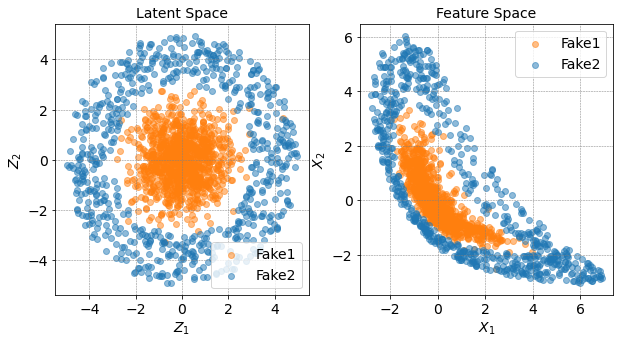

In [24]:
plot_fake_fake(Z_gen, Z_outliers, X_gen, X_outliers)

# Anomalies Detection with WGAN

<center><img src="img/anomalies.png" width=700></center>

**Idea** of this approach is to used WGAN to generate anomalies. Then, we will use a binary classifer to separate normal observations from anomalies. So, the classifier will reconstruct boundaries of the noraml class.

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix

def quality_metrics(y_true, y_pred):
    # calculate quality metrics
    auc = roc_auc_score(y_true, y_pred)
    print("ROC AUC:", auc)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred >= 0.5).ravel()
    print("TP:", tp, "FP:", fp)
    print("FN:", fn, "TN:", tn)

In [26]:
# add generated outliers to our train sample
X_train_ano = np.concatenate((X_train, X_outliers), axis=0)
y_train_ano = np.concatenate((y_train, np.ones(len(X_outliers))))

In [27]:
# define and fit a binary classifier
clf1 = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01, max_depth=6)
clf1.fit(X_train_ano, y_train_ano)

# get predictions for test
y_test_pred_ano = clf1.predict_proba(X_test)[:, 1]

# calculate quality metrics
quality_metrics(y_test, y_test_pred_ano)

ROC AUC: 0.9985714285714287
TP: 19 FP: 15
FN: 1 TN: 965


### Anomalies Detection with Binary Classifier

In [28]:
# define and fit a classifier
clf2 = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01, max_depth=6)
clf2.fit(X_train, y_train)

# get predictions for test
y_test_pred = clf2.predict_proba(X_test)[:, 1]

# calculate quality metrics
quality_metrics(y_test, y_test_pred)

ROC AUC: 0.7518622448979592
TP: 11 FP: 0
FN: 9 TN: 980


### Anomalies Detection with Isolation Forest

In [29]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(n_estimators=1000)
iso.fit(X_test)
y_test_pred = -iso.score_samples(X_test)

# calculate quality metrics
quality_metrics(y_test, y_test_pred)

ROC AUC: 0.9957142857142857
TP: 20 FP: 95
FN: 0 TN: 885


# Bidirectional GAN (BiGAN)

Notations:
- $G: Z \to X$ is Generator;
- $E: X \to Z$ is Encoder;
- $D: X * Z \to P$ is Discriminator

<center><img src="img/bigan.png" width=700></center>

Link: https://arxiv.org/abs/1605.09782

In [30]:
class Encoder(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(n_inputs, 100)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 100)
        self.act2 = nn.ReLU()
        self.fc_out = nn.Linear(100, n_outputs)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc_out(x)
        return x
    

class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(n_inputs, 100)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 100)
        self.act2 = nn.ReLU()
        self.fc_out = nn.Linear(100, 1)

    def forward(self, x, z):
        xz = torch.cat((x,z), dim=1)
        x = self.fc1(xz)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc_out(x)
        return x

In [31]:
class BiFitter(object):
    
    def __init__(self, generator, discriminator, encoder, batch_size=32, n_epochs=10, latent_dim=1, lr=0.0001, n_critic=5):
        
        self.generator = generator
        self.discriminator = discriminator
        self.encoder = encoder
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic
        
        self.opt_gen  = torch.optim.RMSprop(list(self.generator.parameters()) + list(self.encoder.parameters()), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)
        
        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)
        self.encoder.to(DEVICE)
    
    
    def fit(self, X):
        
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        dataset_real = TensorDataset(X_real)
        
        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)
        self.encoder.train(True)
        
        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch,) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)):
                
                # generate a batch of fake objects
                z_batch = Variable(torch.tensor(np.random.normal(0, 1, (len(real_batch), self.latent_dim)), dtype=torch.float, device=DEVICE))
                fake_batch = self.generator(z_batch)
                
                # encode real objects back into latent space
                z_enc_batch = self.encoder(real_batch)
                
                ### Discriminator
                real_output = self.discriminator(real_batch, z_enc_batch)
                fake_output = self.discriminator(fake_batch, z_batch)
                
                ### Loss
                loss_disc = - torch.mean(real_output) + torch.mean(fake_output)
                
                self.opt_disc.zero_grad()
                loss_disc.backward(retain_graph=True)
                self.opt_disc.step()
                
                # Clip weights of discriminator
                for p in discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)
                    
                
                ### Train Generator
                
                if i % self.n_critic == 0:
                    
                    real_output = self.discriminator(real_batch, z_enc_batch)
                    fake_output = self.discriminator(fake_batch, z_batch)
                    
                    loss_gen = - torch.mean(fake_output) + torch.mean(real_output)

                    self.opt_gen.zero_grad()
                    loss_gen.backward()
                    self.opt_gen.step()
                    
            # caiculate and store loss after an epoch
            Z = Variable(torch.tensor(np.random.normal(0, 1, (len(X_real), self.latent_dim)), dtype=torch.float, device=DEVICE))
            X_fake = self.generator(Z)
            Z_enc = self.encoder(X_real)
            real_output = self.discriminator(X_real, Z_enc)
            fake_output = self.discriminator(X_fake, Z)
            loss_epoch = torch.mean(real_output) - torch.mean(fake_output)
            self.loss_history.append(loss_epoch.detach().cpu())
                    
        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)
        self.encoder.train(False)
        
        
    def generate(self, N):
        noise = Variable(torch.tensor(np.random.normal(0, 1, (N, self.latent_dim)), dtype=torch.float, device=DEVICE))
        # noise = Variable(torch.tensor(2*np.random.rand(N, self.latent_dim)-1, dtype=torch.float, device=DEVICE))
        X_gen = self.generator(noise)
        return X_gen
    
    def discriminate(self, X):
        intput = torch.tensor(X, dtype=torch.float, device=DEVICE)
        output = self.discriminator(intput).detach().numpy()
        return output

In [32]:
%%time
latent_dim = 2
generator     = Generator(latent_dim, 2)
encoder       = Encoder(2, latent_dim)
discriminator = Discriminator(2+latent_dim)

fitter = BiFitter(generator, discriminator, encoder, batch_size=50, n_epochs=1000, latent_dim=latent_dim, lr=0.0001, n_critic=5)
fitter.fit(X_train[y_train==0])

CPU times: user 1min 48s, sys: 1.13 s, total: 1min 49s
Wall time: 1min 50s


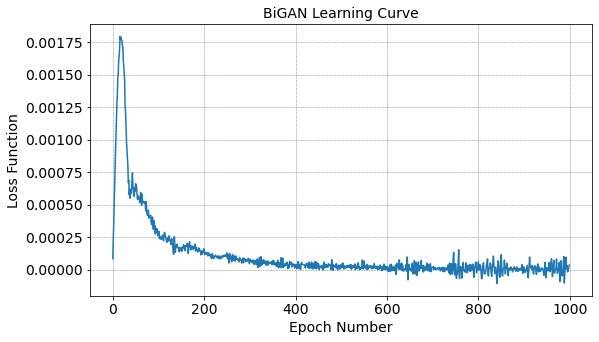

In [33]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("BiGAN Learning Curve", size=14)
plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
plt.show()

Consider how Generator of our BiGAN generates new objects.

### $X = G(Z)$

In [34]:
# sample objects from known distribution in latent space Z
Z_gen = torch.tensor(np.random.normal(0, 1, (len(X_train), latent_dim)), dtype=torch.float, device=DEVICE)
# using object in latent sapce, generate fake objects using the Generator
X_gen = fitter.generator(Z_gen).cpu().detach().numpy()
Z_gen = Z_gen.cpu().detach().numpy()

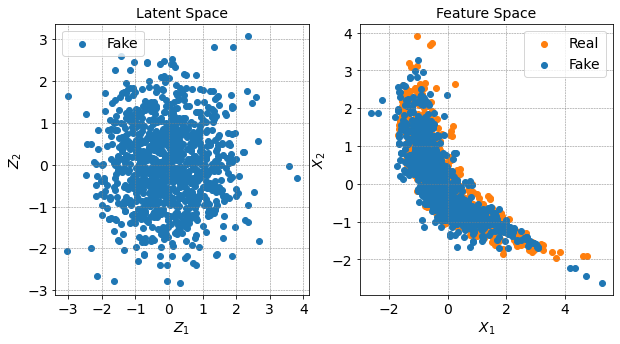

In [35]:
plot_generated_objs(Z_gen, X_gen, X_train[y_train==0])

Now, let's see how Generator of our BiGAN generates new objects.

### $Z = E(X)$

In [36]:
# using object in latent sapce, generate fake objects using the Generator
Z_enc = fitter.encoder(torch.tensor(X_train[y_train==0], dtype=torch.float, device=DEVICE)).cpu().detach().numpy()

In [37]:
def plot_encoded_objs(X, Z_enc):

    plt.figure(figsize=(2*5, 5))

    plt.subplot(1, 2, 2)
    plt.scatter(Z_enc[:, 0], Z_enc[:, 1], label="Encoded objects", color='C0')
    plt.xlabel(r"$Z_1$", size=14)
    plt.ylabel(r"$Z_2$", size=14)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.title("Latent Space", size=14)
    plt.legend(loc='best', fontsize=14)
    plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')

    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], label="Objects", color='C0')
    plt.xlabel(r"$X_1$", size=14)
    plt.ylabel(r"$X_2$", size=14)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.title("Feature Space", size=14)
    plt.legend(loc='best', fontsize=14)
    plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
    plt.show()

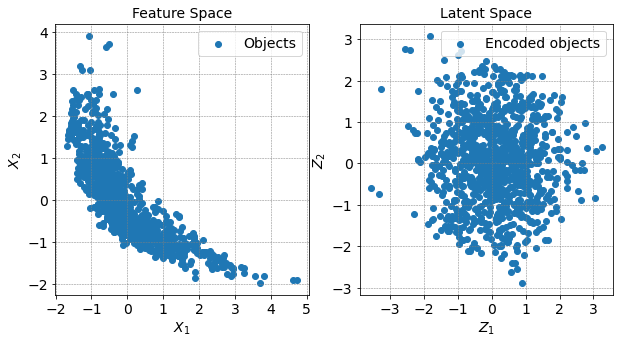

In [38]:
plot_encoded_objs(X_train[y_train==0], Z_enc)

Finally, we explore what will happen if we take an object `x` and pass it through the Encoder `E` and Generator `G` of our BiGAN.

### $Z = E(X)$
### $\hat{X} = G(Z)$
### $\hat{X} = X$ - ?

In [39]:
r_min = 5
r_max = 10

In [40]:
# sample objects in latent space Z uniformly
X_u = np.random.uniform(low=-10, high=10, size=(5000, 2))

# select all objects within r_min and r_max radius
r = np.sqrt(X_u[:, 0]**2 + X_u[:, 1]**2)
X_u = X_u[(r >= r_min)*(r < r_max)]

# generate object in feature space X using the Generator
Z_enc_u = fitter.encoder(torch.tensor(X_u, dtype=torch.float, device=DEVICE)).detach().cpu().numpy()

In [41]:
# using object in latent sapce, generate fake objects using the Generator
Z_enc_gen = fitter.encoder(torch.tensor(X_gen, dtype=torch.float, device=DEVICE)).cpu().detach().numpy()

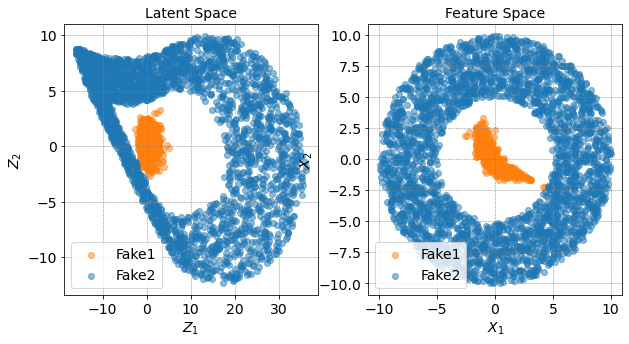

In [42]:
plot_fake_fake(Z_enc_gen, Z_enc_u, X_gen, X_u)

In [43]:
X_enc_gen_u = fitter.generator(torch.tensor(Z_enc_u, dtype=torch.float, device=DEVICE)).detach().cpu().numpy()
X_enc_gen_gen = fitter.generator(torch.tensor(Z_enc_gen, dtype=torch.float, device=DEVICE)).detach().cpu().numpy()

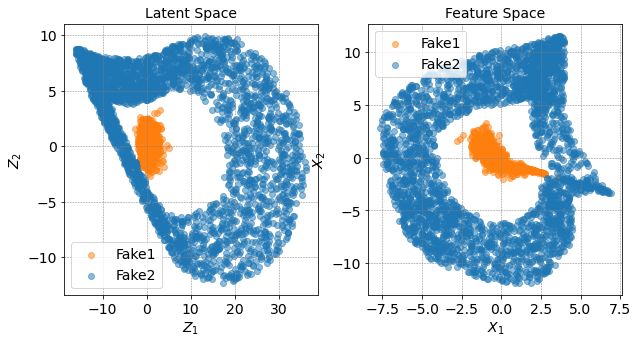

In [44]:
plot_fake_fake(Z_enc_gen, Z_enc_u, X_enc_gen_gen, X_enc_gen_u)

# Anomalies Detection with BiGAN

BiGAN helps to detect anomalies by estimating the following score function $A(x)$:

$$A(x) = \alpha L_{G}(x) + (1 - \alpha)L_{D}(x),$$

where

$$L_{G}(x) = || x - G(E(x)) ||_{1},$$

$$L_{D}(x) = || D(x, E(x)) - D(G(E(x)), E(x)) ||_{1},$$

$\alpha$ is an adjustable parameter.

In [45]:
# calculate E(X)
Z_enc = fitter.encoder(torch.tensor(X_test, dtype=torch.float, device=DEVICE))
# calculate G(E(X))
X_gen = fitter.generator(Z_enc)

# calculate D(X, E(X))
D_real = fitter.discriminator(torch.tensor(X_test, dtype=torch.float, device=DEVICE), Z_enc)
# calculate D(G(E(X)), E(X))
D_gen  = fitter.discriminator(X_gen, Z_enc)

In [46]:
# convert to numpy
Z_enc = Z_enc.detach().cpu().numpy()
X_gen = X_gen.detach().cpu().numpy()

D_real = D_real.detach().cpu().numpy()
D_gen = D_gen.detach().cpu().numpy()

In [47]:
# calculate anomaly score A(x)
alpha = 0.9
L_G = np.abs(X_test - X_gen).sum(axis=1)
L_D = np.abs(D_real - D_gen).sum(axis=1)

A = alpha * L_G + (1 - alpha) * L_D

# calculate quality metrics
auc = roc_auc_score(y_test, A)
print("ROC AUC:", auc)

ROC AUC: 0.9515816326530612


In [48]:
def plot_hist_score(x, y):
    plt.figure(figsize=(7, 4))
    bins = np.linspace(0, x.max(), 21)
    plt.hist(x[y==0], bins=bins, label='Inliers')
    plt.hist(x[y==1], bins=bins, alpha=0.5, label='Outliers')
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.xlabel('Anomaly score', size=14)
    plt.ylim(0, 10)
    plt.legend(loc='best', fontsize=14)
    plt.show()

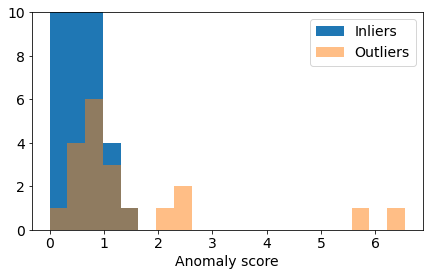

In [49]:
plot_hist_score(A, y_test)

Alternative approach is to calculate the folowing anomaly score:

$$R_{z}(x) = || E(x) ||_2$$

ROC AUC: 0.997857142857143


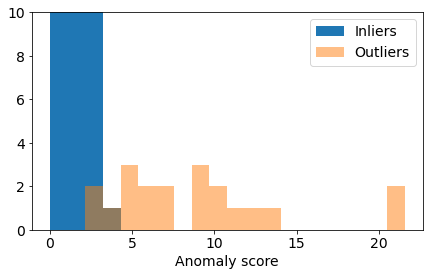

In [50]:
# calculate anomaly score
R_Z = np.sqrt((Z_enc**2).sum(axis=1))

# calculate quality metrics
auc = roc_auc_score(y_test, R_Z)
print("ROC AUC:", auc)

plot_hist_score(R_Z, y_test)

# Resources

Anomalies detection with GANs and VAE:
- https://arxiv.org/abs/1901.03407
- https://arxiv.org/abs/1906.11632

Anomalies detection with Normalizing Flows:
- https://arxiv.org/abs/1912.09323

# For Jedi

Detect anomalies in the following multidimensional case:

In [51]:
n_samples = 4000
outliers_fraction = 0.02
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

In [52]:
label = data[10].values
X_inliers = data[label == 'g'][range(10)].values
X_outliers = data[label == 'h'][range(10)].values

# read inliers
X_inliers = resample(X_inliers, replace=False, n_samples=n_inliers, random_state=42)

# generate outliers
X_outliers = resample(X_outliers, replace=False, n_samples=n_outliers, random_state=42)

In [53]:
# concatenate
X = np.concatenate((X_inliers, X_outliers), axis=0)
y = np.array([0]*len(X_inliers) + [1]*len(X_outliers))

# scale
X = StandardScaler().fit_transform(X)

In [54]:
# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11)